sources: 

- https://www.kaggle.com/hone5com/fraud-detection-with-variational-autoencoder
- https://www.tensorflow.org/probability/api_docs/python/tfp/layers/KLDivergenceRegularizer

In [1]:
# Import TensorFlow >= 1.9 and enable eager execution
import tensorflow as tf
tfe = tf.contrib.eager
tf.enable_eager_execution()

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
#import imageio
from IPython import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from som_vae.helpers.misc import extract_args, chunks, foldl
from som_vae.helpers.jupyter import fix_layout, display_video
from som_vae.settings import config, skeleton
from som_vae.helpers import video, plots, misc, jupyter
from som_vae import preprocessing
from som_vae.helpers.logging import enable_logging
from som_vae.helpers.tensorflow import _TF_DEFAULT_SESSION_CONFIG_

W0427 15:29:51.719887 140475388323648 lazy_loader.py:50] 
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0427 15:29:51.836310 140475388323648 deprecation_wrapper.py:119] From /home/sam/proj/epfl/neural_clustering_vae/som_vae/helpers/tensorflow.py:4: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [2]:
#! conda install tensorflow --yes
#! pip install --upgrade tensorflow-probability

In [3]:
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import os

%matplotlib inline

In [4]:
jupyter.fix_layout()

In [17]:
### Utility Functions
## Plots
# Plot Feature Projection [credit: https://www.kaggle.com/shivamb/semi-supervised-classification-using-autoencoders]
def tsne_plot(x1, y1, name=None):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)
#     plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud', s=2)

    plt.legend(loc='best');
    #plt.savefig(name);
    plt.title('tsne')
    plt.show();
    
    
# Plot Keras training history
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [6]:
from som_vae import settings
from som_vae import preprocessing

joint_positions, normalisation_factors = preprocessing.get_data_and_normalization(settings.data.EXPERIMENTS)

frames_idx_with_labels = preprocessing.get_frames_with_idx_and_labels(settings.data.LABELLED_DATA)[:len(joint_positions)]

#frames_of_interest = frames_idx_with_labels.label.isin([settings.data._BehaviorLabel_.GROOM_ANT, settings.data._BehaviorLabel_.WALK_FORW, settings.data._BehaviorLabel_.REST])
frames_of_interest = ~frames_idx_with_labels.label.isin([settings.data._BehaviorLabel_.REST])

joint_positions = joint_positions[frames_of_interest]
frames_idx_with_labels = frames_idx_with_labels[frames_of_interest]

W0427 15:29:52.064105 140475388323648 preprocessing.py:67] this works only for the first legs!
W0427 15:29:52.069735 140475388323648 preprocessing.py:67] this works only for the first legs!
W0427 15:29:52.074197 140475388323648 preprocessing.py:67] this works only for the first legs!
W0427 15:29:52.078585 140475388323648 preprocessing.py:67] this works only for the first legs!
W0427 15:29:52.083698 140475388323648 preprocessing.py:67] this works only for the first legs!


In [7]:
# flatten the data
reshaped_joint_position = joint_positions[:,:,: config.NB_DIMS].reshape(joint_positions.shape[0], -1).astype(np.float32)


# scaling the data to be in [0, 1]
# this is due to the sigmoid activation function in the reconstruction
scaler = MinMaxScaler()
#resh = scaler.fit_transform(resh)

print(f"total number of input data:{reshaped_joint_position.shape}")


#if som_vae_config['time_series']:
#    _time_series_idx_ = list(to_time_series(range(len(joint_positions))))
#    _jp = np.concatenate([joint_positions[idx].reshape(1, -1, 30) for idx in _time_series_idx_], axis=0)
#else:
#    _jp = joint_positions
#    
#nb_of_data_points = (reshaped_joint_position.shape[0] // config['batch_size']) * config['batch_size']
# train - test split
nb_of_data_points = int(reshaped_joint_position.shape[0] * 0.7)
#
data_train = scaler.fit_transform(reshaped_joint_position[:nb_of_data_points])
data_test = scaler.transform(reshaped_joint_position[nb_of_data_points:])
# just generating some labels, no clue what they are for except validation?
#labels = frames_idx_with_labels['label'].apply(lambda x: x.value).values

#if som_vae_config['time_series']:
#    labels = np.concatenate([labels[idx].reshape(1, -1, 1) for idx in _time_series_idx_], axis=0)

#data = {
#  "X_train": data_train,
#  "X_val": data_test,
#  "y_train": labels[:nb_of_data_points],
#  "y_val": labels[nb_of_data_points:]
#}


total number of input data:(1538, 30)


In [8]:
from tensorflow.contrib.distributions import MultivariateNormalDiag

In [64]:
def dense_layers(sizes):
    return tfk.Sequential([tfkl.Dense(size, activation=tf.nn.leaky_relu) for size in sizes])

tf.reset_default_graph()

original_dim = data_train.shape[1]
input_shape = data_train[0].shape
dense_layer_dims = [20, 10, 8]
latent_dim = 2
batch_size = 128
max_epochs = 1000

# prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_dim), scale=1),
#                         reinterpreted_batch_ndims=1)

prior = MultivariateNormalDiag(loc=tf.zeros([latent_dim]), 
                               scale_identity_multiplier=1.0)

encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape, name='encoder_input'),
    dense_layers(dense_layer_dims),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim), activation=None),
    tfpl.MultivariateNormalTriL(latent_dim, activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
], name='encoder')

encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[latent_dim]),
    dense_layers(reversed(dense_layer_dims)),
    tfkl.Dense(tfpl.IndependentNormal.params_size(original_dim), activation=None),
    tfpl.IndependentNormal(original_dim),
], name='decoder')

decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]),
                name='vae_mlp')

negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.keras.optimizers.Nadam(), 
            loss=negloglik)

vae.summary()
plot_model(vae,
           to_file='vae_mlp.png',
           show_shapes=True)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 8)                 918       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 45        
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 2), (None, 2))    0         
Total params: 963
Trainable params: 963
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 20)                334       
_________________________________________________________________
dense_7 (Dense)              (None, 60)                1260      
____________________________________________

In [10]:
tf_train = tf.data.Dataset.from_tensor_slices((data_train, data_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))
tf_val = tf.data.Dataset.from_tensor_slices((data_test, data_test)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))

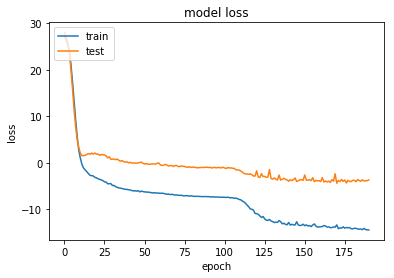

In [11]:
checkpointer = ModelCheckpoint(filepath=f"{config.__DATA_ROOT__}/experimental/model_checkpoints/vae_v2-0.1.0-mdl.h5", verbose=0, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005, patience=20, verbose=0, restore_best_weights=True)

hist = vae.fit(tf_train,
               epochs=max_epochs,
               shuffle=True,
               verbose=0,
               validation_data=tf_val,
               callbacks=[checkpointer, earlystopper])


plot_loss(hist)

# reconstruction

In [12]:
reconstruct_samples_n = 100

def reconstruction_log_prob(eval_samples, reconstruct_samples_n):
    encoder_out = encoder(eval_samples)
    encoder_samples = encoder_out.sample(reconstruct_samples_n)
    return np.mean(decoder(encoder_samples).log_prob(eval_samples), axis=0)

In [ ]:
def _reverse_to_original_shape_(pos_data, input_shape=None):
    if input_shape is None:
        if config.NB_DIMS == 2:
            input_shape = (-1, config.NB_DIMS)
        else:
            input_shape = (-1,)
        
    return scaler.inverse_transform(pos_data).reshape(pos_data.shape[0], *(input_shape))

reconstructed_train =  _reverse_to_original_shape_()

In [ ]:
plots.plot_comparing_joint_position_with_reconstructed(joint_positions, 
                                                       np.vstack((reconstructed_from_encoding_train, reconstructed_from_encoding_val)), validation_cut_off=nb_of_data_points)

# latent space plot

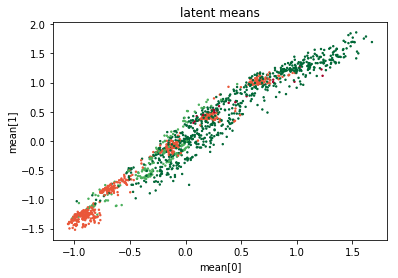

In [42]:
Y = frames_idx_with_labels.label.apply(lambda x: x.value)
X = np.vstack((data_train, data_test))
latent_x_mean = encoder(X).mean()
latent_x_stddev  = encoder(X).stddev()

plt.scatter(latent_x_mean[:, 0], latent_x_mean[:, 1], c=Y, cmap='RdYlGn_r', s=2)
plt.title('latent means')
plt.ylabel('mean[1]')
plt.xlabel('mean[0]')
plt.show()

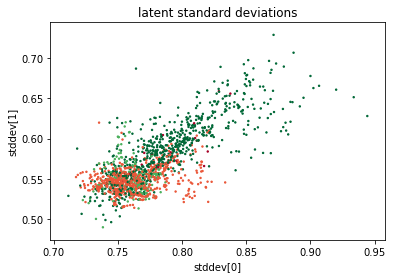

In [40]:
plt.scatter(latent_x_stddev[:, 0], latent_x_stddev[:, 1], c=Y, cmap='RdYlGn_r', s=2)
plt.title('latent standard deviations')
plt.ylabel('stddev[1]')
plt.xlabel('stddev[0]')
plt.show()

## sampling

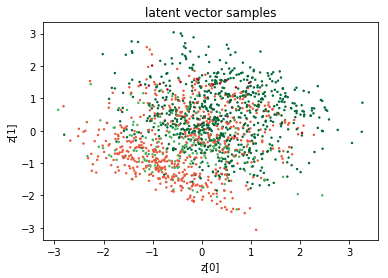

In [43]:
latent_x = encoder(X).sample()
plt.scatter(latent_x[:, 0], latent_x[:, 1], c=Y, cmap='RdYlGn_r', s=2)
plt.title('latent vector samples')
plt.ylabel('z[1]')
plt.xlabel('z[0]')
plt.show()

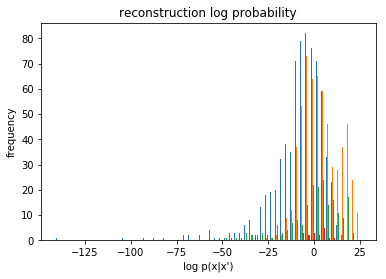

In [49]:
x_log_prob = reconstruction_log_prob(X, reconstruct_samples_n)
#ax = plt.hist(x_log_prob, 60)
plt.hist([x_log_prob[frames_idx_with_labels['label'] == l] for l in seen_labels], 60)
plt.title('reconstruction log probability')
plt.ylabel('frequency')
plt.xlabel("log p(x|x')")
plt.show()